# The Shapely Module

## What is Shapely?

Shapely is a Python module for the manipulation and analysis of planar geometric objects.

![OGC Simple Features Access model](https://dataat.github.io/introducao-analise-de-dados-espaciais/res/1_intro/OGC_FIG.png)

This figure shows a simplified class diagram of the Simple Features Access model. Points are represented by Point objects, lines by LineString objects, and polygons by the Polygon objects. Collections of points, lines and
polygons are represented by the container classes MultiPoint, MultiLineString
and MultiPolygon respectively.

Polygons are constructed from LineStrings,
and LineStrings are constructed from points.

The other boxes are abstract
classes and only show the abstract  relationships between the various spatial objects. In practice only the classes in blue
boxes are used in Python code using the Shapely module.

## Point data type

The point data type in shapely is implemented by a Point class. The geometry element Point (note the capital letter!) takes coordinates as parameters.

The coordinate values of points can be accessed through x, y, and z attributes using dot-notation. Below, we only consider the x and y dimensions of coordinates in a Cartesian plane (no coordinate projection), and leave out the height dimension z.

A Point object is simply constructed by "calling" the class Point with the appropriate coordinates x and y. Point objects store the coordinates in attributes called–not surprisingly–x and y. The attributes are accessed using the dot-notation.

But first we have to ensure the data files exist!

In [4]:
import os

print(os.path.exists('/content/drive/MyDrive/Colab Notebooks/deaths.txt'))
print(os.path.exists('/content/drive/MyDrive/Colab Notebooks/pumps.txt'))

True
True


If these files are missing, please go back to the canvas page and follow the instructions to download the required data files.

In the following code we import the class Point of Shapely and create the point object with coordinates 10.0, 10.0.

In [5]:
from shapely.geometry import Point

point = Point(10.0, 10.0)
print(point.x, point.y)

10.0 10.0


## LineStrings

By definition a line is made up by two or more points. These can be assembled
into a LineString by specifying an ordered set of coordinates. LineString objects
can simply be constructed from a list of coordinate tuples.

For instance, in the
following code we construct a line from the points (1, 2) to (3, 4). Immediately the
line object is also aware of its total length. The length of a line can be obtained
from its `length` attribute.

First, we import the LineString class of Shapely.

In [6]:
from shapely.geometry import LineString

line = LineString([(1, 2), (3, 4)])
line.length

2.8284271247461903

## Polygons

A polygon is created by specifying a sequence representing a closed ring as
below. If the final coordinates do not close the ring but are located close to the
first coordinate, the polygon will (conveniently) be closed automatically.

But first we have to import the Polygon class of Shapely.

In [7]:
from shapely.geometry import Polygon

polygon = Polygon([(1,1),(4, 1),(4,4),(1,4),(1,1)])
polygon.area

9.0

## MultiPoints, MultiLines, MultiPolygons

Collections of points are implemented by a MultiPoint class, collections of
curves by a MultiLineString class, and collections of surfaces by a MultiPolygon class. These collections are not computationally significant, but are useful
for representing certain types of features. A Y-shaped line feature, for exam-
ple, is well-modelled as a whole by a MultiLineString. A MultiPoint geometry
is created by specifying a sequence of coordinates, or an existing list of point
coordinate tuples. With the `wkt` attribute
the MultiPoint object is represented in the well-known text format. Check, for instance, Wikipedia:
![Well-known text representation of geometry](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry).

In [10]:
from shapely.geometry import MultiPoint

mypointlist = [(1,1),(2,2),(3,3),(4,4)]

points = MultiPoint(mypointlist)

points.wkt

'MULTIPOINT (1 1, 2 2, 3 3, 4 4)'

In the remainder of this document, we illustrate the application of spatial data
processing with an example of one of the first uses of spatial analysis in solving health problems.

## Example: John Snow and his cholera map

There is some debate as to the specifics of this event, but it is generally accepted
to be one of the first uses of spatial analysis in solving health problems.
As the story goes, British physician Dr John Snow was attempting to identify the nature and cause of the Cholera outbreak in London in the 1850's. He
suspected that the deaths had something to do with the water supply, so he
used a point map to locate all the deaths and also all of the pumps in the area.

His simple but effective approach was to look at the distributions of deaths
relative to each water pump, and he was able to conclude that one of the pumps
(and therefore the well it pumped water from) seemed to be causing the problems. The pump handle of the suspected pump was removed, with an observable reduction in the ensuing number of new Cholera cases. And thus he
demonstrated that cholera is a waterborne disease. This was not previously
understood. The map is the most famous and classical example in the field of
medical cartography.

The data is made available in two files which were digitized from the original map included in the book by John Snow. The scale of the source map is approx. 1:2000. Coordinate units are meters. The data in these files consists of:
- the location of 578 deaths from cholera `deaths.txt`
- the position of 13 water pumps `pumps.txt`

Each coordinate point in the file `deaths` specifies the address of a person
who died from cholera. When many points are associated with a single street
address, they are ”stacked” in a line away from the street so that they are more
easily visualized. This is how they are displayed on John Snow's original map

For an algorithmic solution to this problem, we can formulate the following
steps:
```text
Read the deaths location data from file
Read the pump location data from file

For each pump:
    Find the cases that might be attributed to this pump
        Sum all the number of death cases for this pump
        Store it for the current pump
    Remember the pump with highest count of death cases so far

Print the location of the pump with the largest number of deaths
```

Let us now formulate a computational solution to this problem. The solution should loop over each well point, sum the relevant death cases, and when
done, find the well with the highest total deaths in its vicinity.

One issue is how to determine which 'cases' belong to which well. There
are various ways to do this, but a simple method is to create an equidistant
area around each well (also known as a 'buffer') and then count the number of
cases or deaths that occurred within it.

Using this approach, one would expect that the area with the highest frequency of deaths should be investigated further. Of course this is quite a simplification, but as with most analytical approaches, it is good to begin with a simple approach and gradually develop more complexity.

Let's begin with a
simple case for creating a buffer around a point:

In [11]:
from shapely.geometry import Point

case = Point(10,20)
casearea = case.buffer(20)
print(type(casearea))
print(casearea.area)

<class 'shapely.geometry.polygon.Polygon'>
1254.619396218376


We can also write this in much more efficient notation, using point methods.
For example, to find the area of the buffer zone as above:

In [13]:
(Point(10,20).buffer(20)).area

1254.619396218376

It is time to solve the remainder of the issues. We need to read the data,
loop over all of the pumps, create a buffer for each, and count the number of
deaths within the service area of a pump.

First we import the standard Python module csv for reading csv files. The
data files are simple comma-separated values, one coordinate pair per line, and
the csv module is perfectly suited for reading the data for us.

Furthermore we need to import the MultiPoint class from shapely.

And we encapsulate the reading of the text files in a function for loading csv
data files. The comment in the code explains how it’s done.

In [17]:
import csv
from shapely.geometry import MultiPoint

def read_csv(filename):
  # open the file for reading
  f = open(filename, 'r')
  # create a csv reader object
  # this can read the Comma Separated Values file format
  # default field delimiter is a comma ','
  # and strings are automatically converted to floats
  cr = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
  # read the entire file into a list of [x, y] coordinates
  l = list(cr)
  # delete the csv reader object
  del cr
  # and close the file
  f.close()
  #return the list of coordinates
  return l

Now it's time to read the data and start the analysis. Read the csv data files
into a list of x and y coordinates.

What do these lists look like?

In [18]:
death_list = read_csv('/content/drive/MyDrive/Colab Notebooks/deaths.txt')
pump_list = read_csv('/content/drive/MyDrive/Colab Notebooks/pumps.txt')

And directly convert these lists into MultiPoint geometries.

In [19]:
deaths = MultiPoint(death_list)
pumps = MultiPoint(pump_list)

Now we have to find the maximum value of deaths per pump service area.
The trick here is to define the pump service area as a buffer zone of distance
of 3 units around the pump.

The crucial operation in these lines of code is the
following expression:
```python
deaths_per_pump = pumps[i].buffer(3).intersection(deaths)
```

In this line we calculate a buffer around pump number `i` and intersect this
circle with the multi-point collection of death cases. The result of this intersection should be 0, 1, or more points. Zero points will be returned as a GeometryCollection object. One Point will be returned as a single Point object. More
points will be returned as a MultiPoint object.

Counting is easy by counting the
number of objects in a collection by calling the standard `len()` function. However, unfortunately, a Point object is is not a collection and trying to determine
the `len()` of a Point object will fail and raise an exception. In the code below we
simply catch the error with a trystatement and set death count to 1 on an error.

The last if-statement keeps track of the pump with the largest number of
death cases.

In [24]:
max_deaths = 0

# loop over the pumps
for i in range(len(pumps.geoms)):
  # per per pump zone get the deaths in that zone
  # a pump zone is a buffer around the pump at distance 3
  deaths_per_pump = pumps.geoms[i].buffer(3).intersection(deaths)

  # The catch here is that the intersection returns either:
  # - an GeometryCollection that contains zero Points, or
  # - a single Point object, or
  # - a MultiPoint object containing multiple Points
  # Only GeometryCollection and MultiPoint are sequences!
  # We use a try-statement here to catch errors and
  # set the count to 1 in case of a Point.

  try:
    death_count = len(deaths_per_pump)
  except:
    death_count = 1

  # keep track of the maximum and this pump number
  if death_count > max_deaths:
    max_deaths = death_count
    max_pump = i

When the loop is finished it is easy to get the pump point with the maximum death count.

Finally, we print the coordinates of the pump in the well-known text format (WKT).

In [25]:
the_pump = pumps.geoms[max_pump]
print(the_pump.wkt)

POINT (8.6512012 17.8915997)


Putting it all together, and leaving out the comment lines, gives us a compact code that finds the fouled pump:

In [31]:
import csv
from shapely.geometry import MultiPoint

def read_csv(filename):
  f = open(filename, 'r')
  cr = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
  l = list(cr)
  del cr
  f.close()
  return l

death_list = read_csv('/content/drive/MyDrive/Colab Notebooks/deaths.txt')
pump_list = read_csv('/content/drive/MyDrive/Colab Notebooks/pumps.txt')

deaths = MultiPoint(death_list)
pumps = MultiPoint(pump_list)

max_deaths = 0

for i in range(len(pumps.geoms)):
  deaths_per_pump = pumps.geoms[i].buffer(3).intersection(deaths)

  death_count = 1 if isinstance(deaths_per_pump, Point) else len(deaths_per_pump.geoms)
  if death_count > max_deaths:
    max_deaths = death_count
    max_pump = i

the_pump = pumps.geoms[max_pump]
print(the_pump.wkt)

POINT (12.5713596 11.72717)


With a bit of effort we can plot all the data. With the suspected pump as a cyan diamond marker. Pumps as black stars, buffers as blue circles, death cases as red dots.

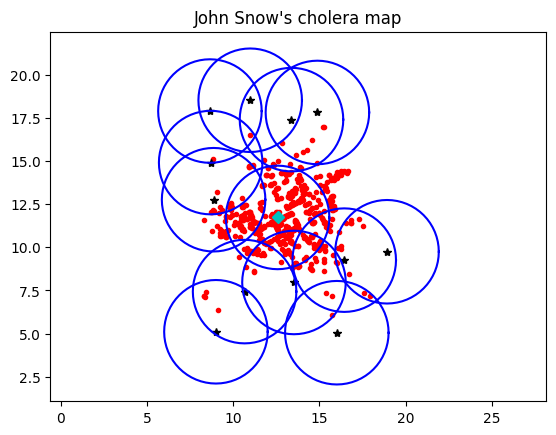

In [37]:
# Plotting it
from pylab import *

# function for plotting a multipoint layer
def plot_multipoint(mp, fmt):
    for p in mp.geoms:
        plot(p.x, p.y, fmt)

# function for plotting the buffers
def plot_buffers(mp, radius, fmt):
    for p in mp.geoms:
        x, y = zip(*p.buffer(radius).exterior.coords)
        plot(x, y, fmt)

# plot the deaths
plot_multipoint(deaths, '.r')

# plot the pumps
plot_multipoint(pumps, '*k')

# plot the buffers around the pumps
plot_buffers(pumps, 3, '-b')

# plot the foul pump
plot(the_pump.x, the_pump.y, 'Dc',)

# give the plot a title
title('John Snow\'s cholera map')

# make the axis have equal spacing
axis('equal');